In [1]:
import timeit
import seaborn as sns
import sys
import time
from tqdm import tqdm

In [11]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import missingno as msn
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from sklearn.ensemble import RandomForestRegressor
from tsfresh.utilities.dataframe_functions import impute

from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.feature_extraction import MinimalFCParameters, EfficientFCParameters ,ComprehensiveFCParameters,feature_calculators

In [3]:
train=pd.read_csv('C:\\Users\\gurbaksh\\Desktop\\Time series\\train.csv')
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
data=train

In [5]:
def store_item_combination(ts,store,item):
    selected_sales=ts[(ts['store']==store)&(ts['item']==item)].sales
    return selected_sales

X=pd.DataFrame()
for item in set(train.item):
    for store in set(train.store):
        X[str(item)+'_'+str(store)]=np.array(store_item_combination(train,store,item))
        

        
X['date']=train['date']
X=X[['date']+list(X.columns[:-1])]        

In [6]:
X.head()

,date,1_1,1_2,1_3,1_4,1_5,1_6,1_7,1_8,1_9,...,50_1,50_2,50_3,50_4,50_5,50_6,50_7,50_8,50_9,50_10
0,2013-01-01,13,12,19,10,11,20,7,16,11,...,30,43,45,38,19,20,21,45,36,33
1,2013-01-02,11,16,8,12,9,6,4,10,9,...,32,57,47,35,25,23,30,54,44,37
2,2013-01-03,14,16,10,8,12,11,8,12,20,...,25,45,39,32,28,38,20,54,29,46
3,2013-01-04,13,20,15,15,8,7,7,21,22,...,32,45,48,36,27,33,27,52,43,51
4,2013-01-05,10,16,22,19,13,12,8,15,22,...,35,55,46,47,31,33,18,48,53,41


In [7]:
['agg_autocorrelation']

['agg_autocorrelation']

In [8]:
feature_calculators.agg_autocorrelation(X['1_1'],param=[{'f_agg': 'mean', 'maxlag':7},{'f_agg': 'mean', 'maxlag':30},{'f_agg': 'mean', 'maxlag':60}
                                                       ,{'f_agg': 'min', 'maxlag':7}])

[('f_agg_"mean"__maxlag_7', 0.41178362614524644),
 ('f_agg_"mean"__maxlag_30', 0.37618296513022975),
 ('f_agg_"mean"__maxlag_60', 0.32014349072441534),
 ('f_agg_"min"__maxlag_7', 0.34530168527563754)]

In [9]:
list(feature_calculators.agg_linear_trend(X['1_1'],param=[{'attr':'stderr' ,'chunk_len':30, 'f_agg':'mean'},
                                                         {'attr':'pvalue' ,'chunk_len':30, 'f_agg':'min'},
                                                         {'attr':'stderr' ,'chunk_len':30, 'f_agg':'max'},
                                                         {'attr':'stderr' ,'chunk_len':30, 'f_agg':'median'}]))

[('f_agg_"mean"__chunk_len_30__attr_"stderr"', 0.027171074470892457),
 ('f_agg_"min"__chunk_len_30__attr_"pvalue"', 0.014385439974696265),
 ('f_agg_"max"__chunk_len_30__attr_"stderr"', 0.04390534665586175),
 ('f_agg_"median"__chunk_len_30__attr_"stderr"', 0.027657469837923238)]

In [10]:
settings={
'standard_deviation': None,
 'variance': None,
 'skewness': None,
 'kurtosis': None,
 'absolute_sum_of_changes': None,

'last_location_of_maximum': None,
 'first_location_of_maximum': None,
 'last_location_of_minimum': None,
'first_location_of_minimum': None,
'count_above_mean': None,
 'count_below_mean': None,
 'maximum': None,
 'minimum': None,
    'longest_strike_below_mean':None,
    'longest_strike_above_mean':None,
    'mean_change':None,
    'mean_abs_change':None,
    'mean_second_derivative_central':None,
    'percentage_of_reoccurring_datapoints_to_all_datapoints':None,
    'sample_entropy':None,
    'skewness':None,
   
    
    'quantile': [{'q': .25}, {'q': .5}, {'q': .75}],
    
'partial_autocorrelation': [{'lag': 30}, {'lag': 7}, {'lag': 180},{'lag': 360},{'lag': 15},{'lag': 60},{'lag': 90},{'lag': 8}],
     
    
 'c3': [{'lag': 100}, {'lag': 200}, {'lag': 3000},{'lag': 10000}],

'number_peaks': [{'n': 7}, {'n':30},{'n': 50},{'n': 100}],
    
'symmetry_looking': [{'r': .25}, {'r': .5}],

#--Calculates a linear least-squares regression for values of the time series that were aggregated 
    #--over chunks versus the sequence from 0 up to the number of chunks minus one.
    
 'agg_linear_trend': [
     {'attr': 'rvalue', 'chunk_len': 500, 'f_agg': 'max'},
  {'attr': 'rvalue', 'chunk_len': 500, 'f_agg': 'min'},
  {'attr': 'rvalue', 'chunk_len': 500, 'f_agg': 'mean'},
  {'attr': 'rvalue', 'chunk_len': 500, 'f_agg': 'var'},
  {'attr': 'rvalue', 'chunk_len': 1000, 'f_agg': 'max'},
  {'attr': 'rvalue', 'chunk_len': 1000, 'f_agg': 'min'},
  {'attr': 'rvalue', 'chunk_len': 1000, 'f_agg': 'mean'},
  {'attr': 'rvalue', 'chunk_len': 1000, 'f_agg': 'var'},
  {'attr': 'intercept', 'chunk_len': 500, 'f_agg': 'max'},
  {'attr': 'intercept', 'chunk_len': 500, 'f_agg': 'min'},
  {'attr': 'intercept', 'chunk_len': 500, 'f_agg': 'mean'},
  {'attr': 'intercept', 'chunk_len': 500, 'f_agg': 'var'},
  {'attr': 'intercept', 'chunk_len': 1000, 'f_agg': 'max'},
  {'attr': 'intercept', 'chunk_len': 1000, 'f_agg': 'min'},
  {'attr': 'intercept', 'chunk_len': 1000, 'f_agg': 'mean'},
  {'attr': 'intercept', 'chunk_len': 1000, 'f_agg': 'var'},
  {'attr': 'slope', 'chunk_len': 500, 'f_agg': 'max'},
  {'attr': 'slope', 'chunk_len': 500, 'f_agg': 'min'},
  {'attr': 'slope', 'chunk_len': 500, 'f_agg': 'mean'},
  {'attr': 'slope', 'chunk_len': 500, 'f_agg': 'var'},
  {'attr': 'slope', 'chunk_len': 1000, 'f_agg': 'max'},
  {'attr': 'slope', 'chunk_len': 1000, 'f_agg': 'min'},
  {'attr': 'slope', 'chunk_len': 1000, 'f_agg': 'mean'},
  {'attr': 'slope', 'chunk_len': 1000, 'f_agg': 'var'},

  {'attr': 'stderr', 'chunk_len': 500, 'f_agg': 'max'},
  {'attr': 'stderr', 'chunk_len': 500, 'f_agg': 'min'},
  {'attr': 'stderr', 'chunk_len': 500, 'f_agg': 'mean'},
  {'attr': 'stderr', 'chunk_len': 500, 'f_agg': 'var'},
  {'attr': 'stderr', 'chunk_len': 1000, 'f_agg': 'max'},
  {'attr': 'stderr', 'chunk_len': 1000, 'f_agg': 'min'},
  {'attr': 'stderr', 'chunk_len': 1000, 'f_agg': 'mean'},
  {'attr': 'stderr', 'chunk_len': 1000, 'f_agg': 'var'}],
     
 'index_mass_quantile': [{'q': 0.1}, #--return relative index of quantile value from time series
  {'q': 0.2},
  {'q': 0.3},
  {'q': 0.4},
  {'q': 0.6},
  {'q': 0.7},
  {'q': 0.8},
  {'q': 0.9}],

 'spkt_welch_density': [{'coeff': 2}, {'coeff': 5}, {'coeff': 8}],

#--unconditional maximum likelihood of an autoregressive AR(k) process. The k parameter is the maximum lag of the process
 'ar_coefficient': [{'coeff': 0, 'k': 10},
  {'coeff': 1, 'k': 10},
  {'coeff': 2, 'k': 10},
  {'coeff': 3, 'k': 10},
  {'coeff': 4, 'k': 10}],
 
#Calculates the sum of squares of chunk i out of N chunks 
#expressed as a ratio with the sum of squares over the whole series.
 'energy_ratio_by_chunks': [{'num_segments': 10, 'segment_focus': 0},
  {'num_segments': 10, 'segment_focus': 1},
  {'num_segments': 10, 'segment_focus': 2},
  {'num_segments': 10, 'segment_focus': 3},
  {'num_segments': 10, 'segment_focus': 4},
  {'num_segments': 10, 'segment_focus': 5},
  {'num_segments': 10, 'segment_focus': 6},
  {'num_segments': 10, 'segment_focus': 7},
  {'num_segments': 10, 'segment_focus': 8},
  {'num_segments': 10, 'segment_focus': 9}],
    
 'ratio_beyond_r_sigma': [{'r': 0.5},
  {'r': 1},
  {'r': 1.5},
  {'r': 2},
  {'r': 2.5},
  {'r': 3},
  {'r': 5},
  {'r': 6},
  {'r': 7},
  {'r': 10}],
    
#---First fixes a corridor given by the quantiles ql and qh of the distribution of x. 
#---Then calculates the average, absolute value of consecutive changes of the series x inside this corridor.
    'change_quantiles': [{'ql': 0.0, 'qh': 0.2, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.2, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.2, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.2, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.4, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.4, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.4, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.4, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.6, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.6, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.6, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.6, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.8, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.8, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.8, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 1.0, 'isabs': False, 'f_agg': 'mean'}]

}

In [12]:
data['id']=data['store'].astype('str') +'_'+data['item'].astype('str')

In [13]:
data.head()

,date,store,item,sales,id
0,2013-01-01,1,1,13,1_1
1,2013-01-02,1,1,11,1_1
2,2013-01-03,1,1,14,1_1
3,2013-01-04,1,1,13,1_1
4,2013-01-05,1,1,10,1_1


In [ ]:
res=extract_features(data,column_id='id',
                                 column_sort='date',
                                 column_value="sales",default_fc_parameters=settings)

In [ ]:
res.head()

In [ ]:
#res.to_csv('stores_data_with_feature_extracted.csv',index=False)

In [14]:
res=pd.read_csv('stores_data_with_feature_extracted.csv')

In [15]:
res.shape

(500, 126)

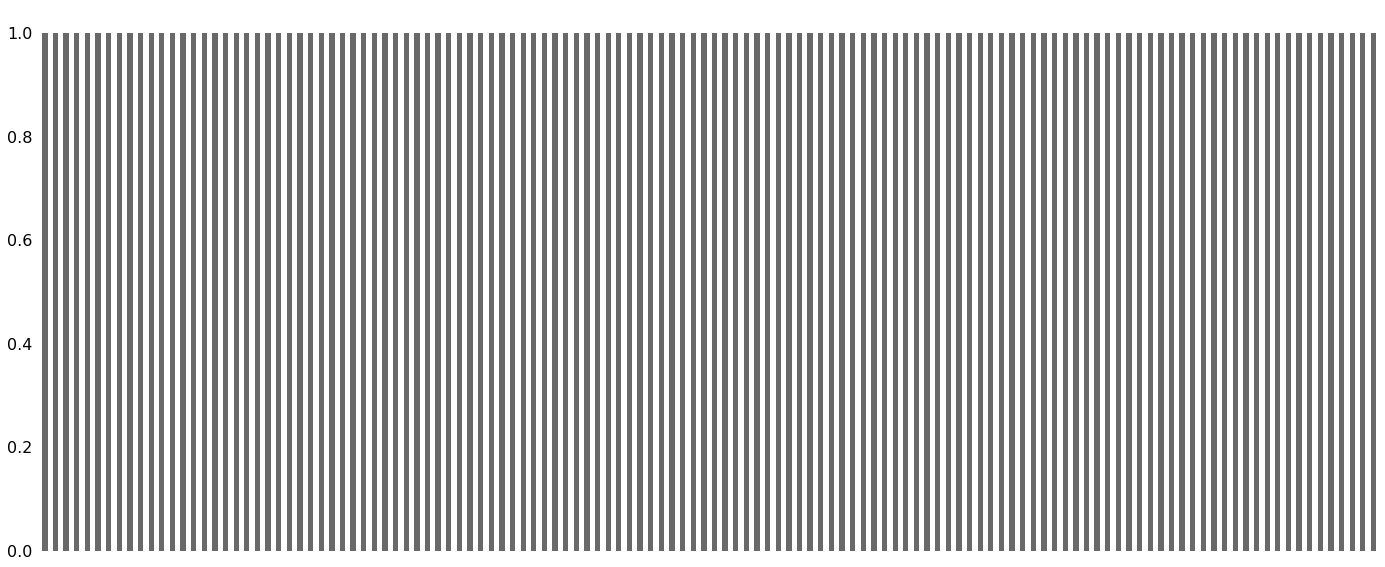

In [16]:
msn.bar(res)

In [17]:
res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 126 entries, sales__absolute_sum_of_changes to sales__variance
dtypes: float64(126)
memory usage: 492.3 KB


In [18]:
res=res.dropna(axis='columns')

In [19]:
res.head()

,sales__absolute_sum_of_changes,"sales__agg_linear_trend__f_agg_""max""__chunk_len_1000__attr_""intercept""","sales__agg_linear_trend__f_agg_""max""__chunk_len_1000__attr_""rvalue""","sales__agg_linear_trend__f_agg_""max""__chunk_len_1000__attr_""slope""","sales__agg_linear_trend__f_agg_""max""__chunk_len_1000__attr_""stderr""","sales__agg_linear_trend__f_agg_""max""__chunk_len_500__attr_""intercept""","sales__agg_linear_trend__f_agg_""max""__chunk_len_500__attr_""rvalue""","sales__agg_linear_trend__f_agg_""max""__chunk_len_500__attr_""slope""","sales__agg_linear_trend__f_agg_""max""__chunk_len_500__attr_""stderr""","sales__agg_linear_trend__f_agg_""mean""__chunk_len_1000__attr_""intercept""",...,sales__ratio_beyond_r_sigma__r_7,sales__sample_entropy,sales__skewness,sales__spkt_welch_density__coeff_2,sales__spkt_welch_density__coeff_5,sales__spkt_welch_density__coeff_8,sales__standard_deviation,sales__symmetry_looking__r_0.25,sales__symmetry_looking__r_0.5,sales__variance
0,12077.0,49.0,1.0,5.0,0.0,40.7,0.916380,5.2,1.606238,23.025,...,0.0,2.240196,0.376202,485.401471,124.216856,82.919212,7.939419,1.0,1.0,63.034375
1,25918.0,138.0,1.0,18.0,0.0,125.2,0.937501,11.7,3.070831,76.376,...,0.0,2.181161,0.325255,4591.086491,702.423735,473.182642,22.040856,1.0,1.0,485.799314
2,25209.0,136.0,1.0,10.0,0.0,124.2,0.949390,8.2,1.918333,72.673,...,0.0,2.161774,0.247453,4861.462274,497.700338,428.577925,21.432869,1.0,1.0,459.367868
3,25818.0,138.0,1.0,9.0,0.0,116.2,0.892766,11.7,4.174925,72.573,...,0.0,2.164598,0.258557,4372.899628,404.765857,687.237379,21.527571,1.0,1.0,463.436325
4,29404.0,164.0,1.0,17.0,0.0,136.5,0.929667,16.0,4.483302,88.032,...,0.0,2.109519,0.294134,6000.337320,569.604941,435.845732,25.033694,1.0,1.0,626.685818


In [20]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
X = sc.fit_transform(res)

In [21]:
# Training the SOM
from minisom import MiniSom
som = MiniSom(x = 5, y = 5, input_len = res.shape[1], sigma = 1.0, learning_rate = 0.5,random_seed=42)
som.random_weights_init(X)
som.train_random(data = X, num_iteration = 100)

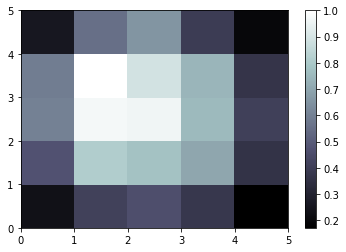

In [22]:
from pylab import bone, pcolor, colorbar, plot, show
bone()
pcolor(som.distance_map().T)
colorbar()

In [23]:
a=som.activation_response(X)
a

array([[51., 44., 22., 17.,  9.],
       [23., 23., 21., 11., 10.],
       [31., 17., 16., 11., 64.],
       [15., 15., 17., 11., 17.],
       [11., 13., 15.,  9.,  7.]])

In [24]:
a=som.distance_map()
a

array([[0.23485598, 0.4747086 , 0.60460809, 0.59059696, 0.25729889],
       [0.41094547, 0.81332986, 0.97233231, 1.        , 0.55320085],
       [0.46080404, 0.77800453, 0.96236786, 0.89175551, 0.65656085],
       [0.37740057, 0.70106259, 0.75678919, 0.74264221, 0.39662778],
       [0.17097719, 0.36015876, 0.40934209, 0.36809633, 0.19847316]])

In [25]:
a=som.labels_map(X,res.index)
cluster_1=[(0,0),(0,4),(4,4),(4,0)]
cls_1=[]
for node in cluster_1:
    for keyvalue in a[node].items():
        key, value = keyvalue[0], keyvalue[1]
        cls_1.append(key)

In [26]:
cluster_2=[(1,3),(1,2),(2,2)]
cls_2=[]
for node in cluster_2:
    for keyvalue in a[node].items():
        
        key, value = keyvalue[0], keyvalue[1]
        cls_2.append(key)

In [27]:
cluster_3=[(3,1),(3,2),(3,3),(2,3),(1,1),(2,1)]
cls_3=[]
for node in cluster_3:
    for keyvalue in a[node].items():
        key, value = keyvalue[0], keyvalue[1]
        cls_3.append(key)

In [28]:
cluster_4=[(0,2),(0,3),(1,4),(2,0)]
cls_4=[]
for node in cluster_4:
    for keyvalue in a[node].items():
        key, value = keyvalue[0], keyvalue[1]
        cls_4.append(key)

In [29]:
data.head()

,date,store,item,sales,id
0,2013-01-01,1,1,13,1_1
1,2013-01-02,1,1,11,1_1
2,2013-01-03,1,1,14,1_1
3,2013-01-04,1,1,13,1_1
4,2013-01-05,1,1,10,1_1


In [30]:
def get_cluster(index):
   # print(index)
    if index in cls_1:
        return 1
    elif index in cls_2:
        return 2
    elif index in cls_3:
        return 3
    elif index in cls_4:
        return 4
    else: return 5

In [31]:
cls_list=[get_cluster(x) for x in res.index.values ]

In [134]:
lst_id=data.id.unique()


In [33]:
dd=pd.DataFrame()
dd['id']=lst_id
dd['cluster']=cls_list
dd.head()

,id,cluster
0,1_1,1
1,2_1,4
2,3_1,5
3,4_1,5
4,5_1,5


In [34]:
data=data.merge(dd,left_on='id',right_on='id',how='left')
data.head()

,date,store,item,sales,id,cluster
0,2013-01-01,1,1,13,1_1,1
1,2013-01-02,1,1,11,1_1,1
2,2013-01-03,1,1,14,1_1,1
3,2013-01-04,1,1,13,1_1,1
4,2013-01-05,1,1,10,1_1,1


In [140]:
from tslearn.clustering import TimeSeriesKMeans 
from sklearn import metrics 
from scipy.spatial.distance import cdist 
import numpy as np 
import matplotlib.pyplot as plt

In [141]:
from yellowbrick.cluster import KElbowVisualizer


In [142]:
visualizer = KElbowVisualizer(TimeSeriesKMeans, k=(7,12))

In [144]:
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show() 

NameError: name 'self' is not defined

In [37]:
km_dba = TimeSeriesKMeans(n_clusters=10,metric="dtw", max_iter=5,
                           max_iter_barycenter=5,
                           random_state=0).fit(X)

In [38]:
clusters=km_dba.predict(X)

C:\Users\gurbaksh\AppData\Local\Continuum\anaconda3\lib\site-packages\tslearn\utils.py:63: UserWarning:

2-Dimensional data passed. Assuming these are 500 1-dimensional timeseries



In [39]:
clusters

array([3, 1, 1, 1, 9, 4, 9, 7, 6, 9, 2, 4, 8, 2, 9, 7, 1, 9, 8, 7, 9, 1,
       6, 2, 4, 2, 1, 7, 1, 1, 5, 9, 2, 3, 0, 3, 2, 8, 0, 9, 4, 3, 8, 6,
       3, 1, 4, 4, 1, 8, 3, 4, 4, 4, 1, 8, 1, 7, 7, 1, 6, 8, 2, 6, 1, 7,
       8, 1, 6, 7, 1, 4, 5, 6, 8, 5, 4, 7, 4, 4, 7, 4, 6, 3, 7, 3, 7, 2,
       7, 1, 8, 3, 2, 7, 3, 8, 8, 8, 4, 2, 7, 9, 9, 1, 9, 1, 9, 7, 2, 9,
       2, 1, 4, 8, 9, 6, 1, 9, 4, 7, 9, 1, 2, 8, 1, 8, 1, 7, 1, 9, 6, 9,
       8, 5, 6, 7, 2, 4, 5, 9, 1, 6, 4, 5, 3, 1, 1, 1, 9, 4, 3, 1, 1, 1,
       9, 4, 9, 3, 6, 9, 0, 4, 8, 2, 9, 7, 1, 9, 8, 3, 9, 1, 0, 0, 4, 8,
       1, 7, 1, 1, 6, 9, 8, 7, 7, 7, 5, 4, 6, 9, 4, 3, 8, 7, 3, 1, 4, 4,
       1, 8, 7, 1, 1, 1, 1, 4, 9, 7, 6, 1, 2, 4, 8, 6, 1, 5, 4, 1, 2, 7,
       9, 1, 2, 2, 8, 2, 1, 5, 4, 1, 7, 1, 2, 7, 7, 7, 6, 8, 7, 1, 4, 7,
       8, 7, 3, 4, 8, 4, 1, 8, 3, 8, 2, 8, 4, 0, 4, 7, 7, 4, 7, 6, 6, 5,
       4, 7, 2, 4, 6, 3, 4, 8, 7, 7, 2, 6, 8, 3, 2, 8, 3, 4, 5, 3, 3, 3,
       7, 6, 3, 4, 2, 3, 6, 7, 3, 2, 2, 2, 4, 5, 3,

In [40]:
lst_id=data.id.unique()
lst_id

array(['1_1', '2_1', '3_1', '4_1', '5_1', '6_1', '7_1', '8_1', '9_1',
       '10_1', '1_2', '2_2', '3_2', '4_2', '5_2', '6_2', '7_2', '8_2',
       '9_2', '10_2', '1_3', '2_3', '3_3', '4_3', '5_3', '6_3', '7_3',
       '8_3', '9_3', '10_3', '1_4', '2_4', '3_4', '4_4', '5_4', '6_4',
       '7_4', '8_4', '9_4', '10_4', '1_5', '2_5', '3_5', '4_5', '5_5',
       '6_5', '7_5', '8_5', '9_5', '10_5', '1_6', '2_6', '3_6', '4_6',
       '5_6', '6_6', '7_6', '8_6', '9_6', '10_6', '1_7', '2_7', '3_7',
       '4_7', '5_7', '6_7', '7_7', '8_7', '9_7', '10_7', '1_8', '2_8',
       '3_8', '4_8', '5_8', '6_8', '7_8', '8_8', '9_8', '10_8', '1_9',
       '2_9', '3_9', '4_9', '5_9', '6_9', '7_9', '8_9', '9_9', '10_9',
       '1_10', '2_10', '3_10', '4_10', '5_10', '6_10', '7_10', '8_10',
       '9_10', '10_10', '1_11', '2_11', '3_11', '4_11', '5_11', '6_11',
       '7_11', '8_11', '9_11', '10_11', '1_12', '2_12', '3_12', '4_12',
       '5_12', '6_12', '7_12', '8_12', '9_12', '10_12', '1_13', '2_13',
    

In [41]:
dd=pd.DataFrame()
dd['id']=lst_id
dd['kmeans_cluster']=clusters
dd

,id,kmeans_cluster
0,1_1,3
1,2_1,1
2,3_1,1
3,4_1,1
4,5_1,9
...,...,...
495,6_50,4
496,7_50,4
497,8_50,4
498,9_50,1


In [42]:
data=data.merge(dd,left_on='id',right_on='id',how='left')
data.head()

,date,store,item,sales,id,cluster,kmeans_cluster
0,2013-01-01,1,1,13,1_1,1,3
1,2013-01-02,1,1,11,1_1,1,3
2,2013-01-03,1,1,14,1_1,1,3
3,2013-01-04,1,1,13,1_1,1,3
4,2013-01-05,1,1,10,1_1,1,3


In [43]:
som_data=data.groupby(['date','cluster'],as_index=False).agg({'sales':'sum','item':'count','store':'count'})
kmeans_data=data.groupby(['date','kmeans_cluster'],as_index=False).agg({'sales':'sum','item':'count','store':'count'})

In [44]:
som_data.head()

,date,cluster,sales,item,store
0,2013-01-01,1,2091,78,78
1,2013-01-01,2,1322,48,48
2,2013-01-01,3,2621,94,94
3,2013-01-01,4,2177,80,80
4,2013-01-01,5,5485,200,200


In [45]:
som_data[som_data.cluster==1].head()

,date,cluster,sales,item,store
0,2013-01-01,1,2091,78,78
5,2013-01-02,1,2072,78,78
10,2013-01-03,1,2282,78,78
15,2013-01-04,1,2465,78,78
20,2013-01-05,1,2450,78,78


### cluster mean

In [133]:
a=som_data.groupby(['date','cluster'],as_index=False).mean()
fig = px.line(a, x="date", y="sales",line_group='cluster',color='cluster')
fig.update_xaxes(rangeslider_visible=True)
fig.show()



In [130]:
a=kmeans_data.groupby(['date','kmeans_cluster'],as_index=False).mean()
fig = px.line(a, x="date", y="sales",line_group='kmeans_cluster',color='kmeans_cluster')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [46]:
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from sklearn.ensemble import AdaBoostRegressor
from tsfresh.utilities.dataframe_functions import impute

import warnings
warnings.filterwarnings('ignore')

In [184]:
d=som_data[som_data.cluster==1]

In [185]:
d.head()

,date,cluster,sales,item,store
0,2013-01-01,1,2091,78,78
5,2013-01-02,1,2072,78,78
10,2013-01-03,1,2282,78,78
15,2013-01-04,1,2465,78,78
20,2013-01-05,1,2450,78,78


In [191]:
d.index=pd.to_datetime(d['date'].values)
d=d.sort_values('date')

In [91]:
from sklearn.metrics import davies_bouldin_score ,silhouette_score

  


In [97]:
print('Silhouette score for som cluster:- ',silhouette_score(som_data['sales'].values.reshape(-1,1), som_data['cluster'].values.reshape(-1,1)))
print('Kmeans score for som cluster:- ',silhouette_score(kmeans_data['sales'].values.reshape(-1,1), kmeans_data['kmeans_cluster'].values.reshape(-1,1))) 

Silhouette score for som cluster:-  0.09381120954945137
Kmeans score for som cluster:-  -0.020180316347345944


In [96]:
print('SOM Cluster:-',davies_bouldin_score(som_data['sales'].values.reshape(-1,1), som_data['cluster'].values.reshape(-1,1)))
print('Kmeans_cluster:- ',davies_bouldin_score(kmeans_data['sales'].values.reshape(-1,1), kmeans_data['kmeans_cluster'].values.reshape(-1,1))) 

SOM Cluster:- 4.186393259424015
Kmeans_cluster:-  6.246031704140848


In [99]:
d.shape

(1826, 5)

In [194]:
1826*30

54780

In [100]:
df_shift, y = make_forecasting_frame(d['sales'], kind="sales", max_timeshift=30, rolling_direction=1)

In [101]:
df_shift.head()

,time,value,id,kind
52490,2013-01-01,1013.0,2013-01-02,sales
50666,2013-01-01,1013.0,2013-01-03,sales
52491,2013-01-02,1076.0,2013-01-03,sales
48843,2013-01-01,1013.0,2013-01-04,sales
50667,2013-01-02,1076.0,2013-01-04,sales


In [102]:
df_shift.shape

(54315, 4)

In [103]:
X = extract_features(df_shift, column_id="id", column_sort="time", column_value="value", impute_function=impute,
                     show_warnings=False)


Feature Extraction: 100%|██████████| 20/20 [01:20<00:00,  4.04s/it]


In [104]:
# drop constant features
print(X.shape)
X = X.loc[:, X.apply(pd.Series.nunique) != 1] 
print(X.shape)

(1825, 756)
(1825, 373)


In [105]:
from tsfresh import select_features

In [60]:
# Add last value as feature
X["feature_last_value"] = y.shift(1)

In [61]:
X.head()

variable,value__abs_energy,value__absolute_sum_of_changes,"value__agg_autocorrelation__f_agg_""mean""__maxlag_40","value__agg_autocorrelation__f_agg_""median""__maxlag_40","value__agg_autocorrelation__f_agg_""var""__maxlag_40","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","value__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""intercept""",...,value__symmetry_looking__r_0.8,value__symmetry_looking__r_0.8500000000000001,value__symmetry_looking__r_0.9,value__symmetry_looking__r_0.9500000000000001,value__time_reversal_asymmetry_statistic__lag_1,value__time_reversal_asymmetry_statistic__lag_2,value__time_reversal_asymmetry_statistic__lag_3,value__variance,value__variance_larger_than_standard_deviation,feature_last_value
id,,,,,,,,,,,,,,,,,,,,,
5,4372281.0,0.0,0.000000,0.000000,0.000000,4916.5,0.598005,30.0,82.272413,4747.952381,...,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.000000,0.0,NaN
10,8665465.0,19.0,-1.000000,-1.000000,0.000000,4916.5,0.598005,30.0,82.272413,4747.952381,...,1.0,1.0,1.0,1.0,0.000000e+00,0.000000e+00,0.0,90.250000,1.0,2072.0
15,13872989.0,229.0,-0.588029,-0.588029,0.069742,4916.5,0.598005,30.0,82.272413,4747.952381,...,1.0,1.0,1.0,1.0,1.730623e+09,0.000000e+00,0.0,8993.555556,1.0,2282.0
20,19949214.0,412.0,-0.600705,-0.868401,0.464756,4916.5,0.598005,30.0,82.272413,4747.952381,...,1.0,1.0,1.0,1.0,2.899762e+09,0.000000e+00,0.0,25547.250000,1.0,2465.0
25,25951714.0,427.0,-0.553093,-0.795074,0.551450,4916.5,0.598005,30.0,82.272413,4747.952381,...,1.0,1.0,1.0,1.0,2.586380e+09,3.720160e+09,0.0,28358.800000,1.0,2450.0


In [62]:
X.shape

(1825, 375)

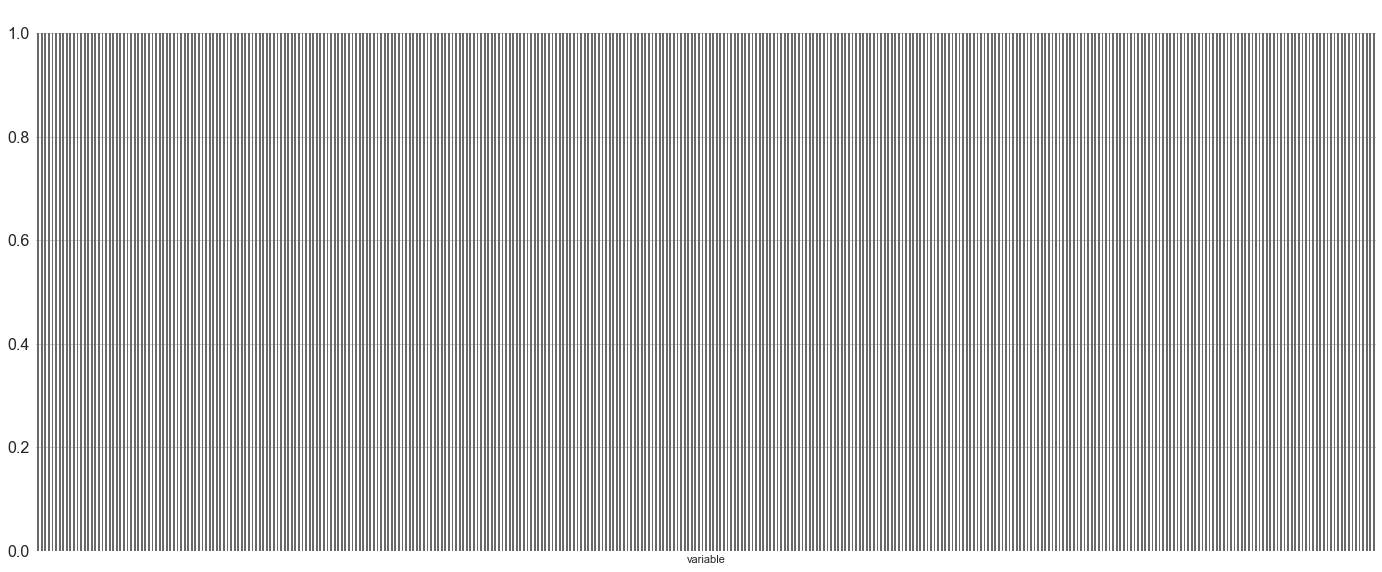

In [63]:
msn.bar(X)

In [64]:
X=X.fillna(X.mean)

In [65]:
X.head()

variable,value__abs_energy,value__absolute_sum_of_changes,"value__agg_autocorrelation__f_agg_""mean""__maxlag_40","value__agg_autocorrelation__f_agg_""median""__maxlag_40","value__agg_autocorrelation__f_agg_""var""__maxlag_40","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","value__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""intercept""",...,value__symmetry_looking__r_0.8,value__symmetry_looking__r_0.8500000000000001,value__symmetry_looking__r_0.9,value__symmetry_looking__r_0.9500000000000001,value__time_reversal_asymmetry_statistic__lag_1,value__time_reversal_asymmetry_statistic__lag_2,value__time_reversal_asymmetry_statistic__lag_3,value__variance,value__variance_larger_than_standard_deviation,feature_last_value
id,,,,,,,,,,,,,,,,,,,,,
5,4372281.0,0.0,0.000000,0.000000,0.000000,4916.5,0.598005,30.0,82.272413,4747.952381,...,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.000000,0.0,<bound method DataFrame.mean of variable valu...
10,8665465.0,19.0,-1.000000,-1.000000,0.000000,4916.5,0.598005,30.0,82.272413,4747.952381,...,1.0,1.0,1.0,1.0,0.000000e+00,0.000000e+00,0.0,90.250000,1.0,2072
15,13872989.0,229.0,-0.588029,-0.588029,0.069742,4916.5,0.598005,30.0,82.272413,4747.952381,...,1.0,1.0,1.0,1.0,1.730623e+09,0.000000e+00,0.0,8993.555556,1.0,2282
20,19949214.0,412.0,-0.600705,-0.868401,0.464756,4916.5,0.598005,30.0,82.272413,4747.952381,...,1.0,1.0,1.0,1.0,2.899762e+09,0.000000e+00,0.0,25547.250000,1.0,2465
25,25951714.0,427.0,-0.553093,-0.795074,0.551450,4916.5,0.598005,30.0,82.272413,4747.952381,...,1.0,1.0,1.0,1.0,2.586380e+09,3.720160e+09,0.0,28358.800000,1.0,2450


In [96]:
del X['feature_last_value']

In [97]:
ada = RandomForestRegressor(n_jobs=3)
y_pred = [np.NaN] * len(y)

isp = 360   # index of where to start the predictions


for i in tqdm(range(isp, len(y),step=7)):  
    ada.fit(X.iloc[:i], y[:i])
    y_pred[i] = ada.predict(X.iloc[i, :].values.reshape((1, -1)))[0]
    
y_pred = pd.Series(data=y_pred, index=y.index)

100%|██████████| 1725/1725 [46:59<00:00,  1.63s/it]


In [104]:
y_pred.tail()

9105    3690.0
9110    3352.4
9115    3466.7
9120    3713.0
9125    4109.6
dtype: float64

In [105]:
y_pred.shape

(1825,)

In [108]:
 #Dataframe of predictions and true values
ys = pd.concat([y_pred, y], axis = 1).rename(columns = {0: 'pred', 'value': 'true'})

# Convert index to a datetime
ys.index = d.index[:-1]
ys.head()

,pred,true
0,NaN,2072
5,NaN,2282
10,NaN,2465
15,NaN,2450
20,NaN,2699


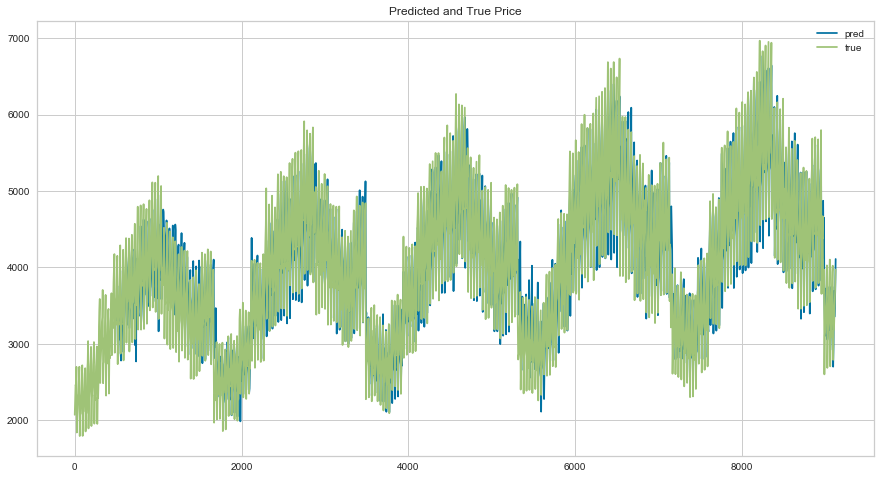

In [109]:
ys.plot(figsize=(15, 8))
plt.title('Predicted and True Price')
plt.show()

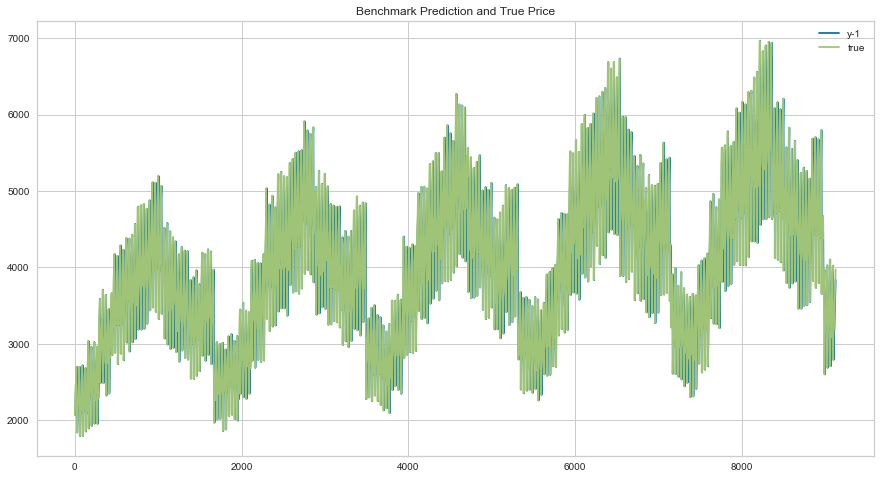

In [110]:

# Create column of previous price
ys['y-1'] = ys['true'].shift(1)
ys[['y-1', 'true']].plot(figsize = (15, 8))
plt.title('Benchmark Prediction and True Price')
plt.show()

In [167]:

print("RMSE: \t{}".format(np.sqrt(mean_squared_error(y[isp:],y_pred[isp:]))))
print("MAPE ada: \t{}".format(np.mean(np.abs((y_pred - y)/y)[isp:])*100))

RMSE: 	246.64991885173046
MAPE ada: 	4.591548165275372


In [174]:
y.mean(),y.max(),y.min()

(4017.1479452054796, 6966, 1794)

In [112]:

importances = pd.Series(index=X.columns, data=ada.feature_importances_)
importances.sort_values(ascending=False).head(10)

variable
value__minimum                                                        0.438524
value__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2    0.068759
value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_9__w_2          0.068206
value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0    0.058822
value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_13__w_2         0.050571
value__quantile__q_0.1                                                0.042769
value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_2__w_2          0.035967
value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_6__w_2          0.029580
value__time_reversal_asymmetry_statistic__lag_1                       0.018331
value__fft_coefficient__coeff_4__attr_"real"                          0.011641
dtype: float64

In [133]:
d2=data[data.cluster==2]

In [135]:
d2.shape

(87648, 7)

In [134]:
df_shift2, y2 = make_forecasting_frame(d2['sales'], kind="sales", max_timeshift=30, rolling_direction=30)

In [136]:
df_shift2

,time,value,id,kind
2541328,20086.0,41.0,20087,sales
2453682,20086.0,41.0,20088,sales
2541329,20087.0,33.0,20088,sales
2366037,20086.0,41.0,20089,sales
2453683,20087.0,33.0,20089,sales
...,...,...,...,...
2278392,900212.0,70.0,900217,sales
2366036,900213.0,52.0,900217,sales
2453681,900214.0,75.0,900217,sales
2541327,900215.0,68.0,900217,sales


In [142]:
X.shape,y.shape

((1825, 374), (1825,))

In [47]:
from tsfresh.feature_selection.significance_tests import target_real_feature_real_test,target_real_feature_binary_test

In [143]:
target_real_feature_real_test(X['value__variance_larger_than_standard_deviation'],y)

0.08952945166946935

In [149]:
num_cols = X._get_numeric_data().columns
num_cols

Index(['value__abs_energy', 'value__absolute_sum_of_changes',
       'value__agg_autocorrelation__f_agg_"mean"__maxlag_40',
       'value__agg_autocorrelation__f_agg_"median"__maxlag_40',
       'value__agg_autocorrelation__f_agg_"var"__maxlag_40',
       'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"intercept"',
       'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"',
       'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"',
       'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"',
       'value__agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"intercept"',
       ...
       'value__symmetry_looking__r_0.75', 'value__symmetry_looking__r_0.8',
       'value__symmetry_looking__r_0.8500000000000001',
       'value__symmetry_looking__r_0.9',
       'value__symmetry_looking__r_0.9500000000000001',
       'value__time_reversal_asymmetry_statistic__lag_1',
       'value__time_reversal_asymmetry_statistic__lag_2',
       'val

In [150]:
list(set(X.columns) - set(num_cols))

[]

In [153]:
hp=pd.DataFrame()
hp['feature']=X.columns
ar=[]
for feature in X.columns:
    p_val=target_real_feature_real_test(X[feature],y)
    ar.append(p_val)
    
    print('p-value of feature ',feature," : ",p_val)
hp['p_val'] =ar   

p-value of feature  value__abs_energy  :  0.0
p-value of feature  value__absolute_sum_of_changes  :  1.2580921248932017e-264
p-value of feature  value__agg_autocorrelation__f_agg_"mean"__maxlag_40  :  9.244926932651322e-10
p-value of feature  value__agg_autocorrelation__f_agg_"median"__maxlag_40  :  3.7451468587288944e-30
p-value of feature  value__agg_autocorrelation__f_agg_"var"__maxlag_40  :  8.993912817592607e-31
p-value of feature  value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"intercept"  :  1.5175929833095343e-230
p-value of feature  value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"  :  5.091427085575785e-10
p-value of feature  value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"  :  8.409707942523104e-09
p-value of feature  value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"  :  0.7321631292636823
p-value of feature  value__agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"intercept"  :  4.520082783607116e-229
p-value of feat

p-value of feature  value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_2  :  7.414357710649062e-11
p-value of feature  value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_20  :  1.0103652345050236e-264
p-value of feature  value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_5  :  4.0367261393990523e-16
p-value of feature  value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_10__w_10  :  2.354711673453793e-249
p-value of feature  value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_10__w_2  :  1.251204636826226e-40
p-value of feature  value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_10__w_20  :  5.012277216299256e-291
p-value of feature  value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_10__w_5  :  3.8388066238202074e-111
p-value of feature  value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_11__w_10  :  3.8694178479648294e-254
p-value of feature  value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_11__w_2  :  0.00014306352327627102
p-value of featur

p-value of feature  value__fft_coefficient__coeff_4__attr_"angle"  :  2.0473119706726978e-15
p-value of feature  value__fft_coefficient__coeff_4__attr_"imag"  :  9.668953743435074e-31
p-value of feature  value__fft_coefficient__coeff_4__attr_"real"  :  2.3267213909771796e-16
p-value of feature  value__fft_coefficient__coeff_5__attr_"abs"  :  1.2707079776608635e-208
p-value of feature  value__fft_coefficient__coeff_5__attr_"angle"  :  1.033421070828954e-12
p-value of feature  value__fft_coefficient__coeff_5__attr_"imag"  :  6.719404560445107e-38
p-value of feature  value__fft_coefficient__coeff_5__attr_"real"  :  2.8174133022790225e-30
p-value of feature  value__fft_coefficient__coeff_6__attr_"abs"  :  2.5309761241835654e-91
p-value of feature  value__fft_coefficient__coeff_6__attr_"angle"  :  0.00035972904950496494
p-value of feature  value__fft_coefficient__coeff_6__attr_"imag"  :  3.1717211254141456e-16
p-value of feature  value__fft_coefficient__coeff_6__attr_"real"  :  1.3253013974

In [158]:
hp.head()

,feature,p_val
0,value__abs_energy,0.0
63,value__c3__lag_3,0.0
202,"value__fft_coefficient__coeff_0__attr_""abs""",0.0
203,"value__fft_coefficient__coeff_0__attr_""real""",0.0
62,value__c3__lag_2,0.0


In [160]:
hp.shape

(374, 2)

In [202]:
hp=hp.sort_values('p_val')
hp[hp.p_val<0.06].head()

,feature,p_val
0,value__abs_energy,0.0
63,value__c3__lag_3,0.0
202,"value__fft_coefficient__coeff_0__attr_""abs""",0.0
203,"value__fft_coefficient__coeff_0__attr_""real""",0.0
62,value__c3__lag_2,0.0


In [201]:

hp[hp.p_val<0.06].feature.values

array(['value__abs_energy', 'value__c3__lag_3',
       'value__fft_coefficient__coeff_0__attr_"abs"',
       'value__fft_coefficient__coeff_0__attr_"real"', 'value__c3__lag_2',
       'value__median', 'value__minimum', 'value__quantile__q_0.1',
       'value__mean', 'value__quantile__q_0.3', 'value__quantile__q_0.4',
       'value__sum_values', 'value__quantile__q_0.2', 'value__c3__lag_1',
       'value__quantile__q_0.6', 'value__quantile__q_0.7',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_14__w_20',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_13__w_20',
       'value__quantile__q_0.8',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_12__w_20',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_11__w_20',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_10__w_20',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_9__w_20',
 

In [205]:
som_data.cluster.unique()

array([1, 2, 3, 4, 5], dtype=int64)

In [60]:
clus_dct={}
for cluster in som_data.cluster.unique():
    
    d=som_data[som_data.cluster==cluster]
    d.index=pd.to_datetime(d['date'].values)
    d=d.sort_values('date')

    df_shift, y = make_forecasting_frame(d['sales'], kind="sales", max_timeshift=30, rolling_direction=1)

    X = extract_features(df_shift, column_id="id", column_sort="time", column_value="value", impute_function=impute,
                         show_warnings=False)

    hp=pd.DataFrame()
    hp['feature']=X.columns
    ar=[]
    for feature in X.columns:
        p_val=target_real_feature_real_test(X[feature],y)
        ar.append(p_val)
    hp['p_val'] =ar 
    hp=hp.sort_values('p_val')
    X=X[hp[hp.p_val<0.06].feature.values]
    
    X=sc.fit_transform(X)
    ada = RandomForestRegressor(n_jobs=3)
    y_pred = [np.NaN] * len(y)

    isp = 360   # index of where to start the predictions


    for i in tqdm(range(isp, len(y))):  
        ada.fit(X[:i], y[:i])
        y_pred[i] = ada.predict(X[i, :].reshape((1, -1)))[0]

    y_pred = pd.Series(data=y_pred, index=y.index)
    rmse=np.sqrt(mean_squared_error(y[isp:],y_pred[isp:]))
    mape=np.mean(np.abs((y_pred - y)/y)[isp:])*100
    print("RMSE: for cluster ",cluster, "\t{} ".format(rmse))
    print("MAPE for cluster",cluster, " \t{} ".format(mape))
    clus_dct[cluster]=[rmse,mape]

100%|██████████| 1465/1465 [21:18<00:00,  1.15it/s]


RMSE: for cluster  1 	241.53374511091357 
MAPE for cluster 1  	4.375302064057596 


100%|██████████| 1465/1465 [18:41<00:00,  1.31it/s]


RMSE: for cluster  2 	162.8710949701997 
MAPE for cluster 2  	4.846534525864693 


100%|██████████| 1465/1465 [18:44<00:00,  1.30it/s]


RMSE: for cluster  3 	303.9112110772323 
MAPE for cluster 3  	4.42588559713549 


100%|██████████| 1465/1465 [18:30<00:00,  1.32it/s]


RMSE: for cluster  4 	256.915775524413 
MAPE for cluster 4  	4.416315813805049 


100%|██████████| 1465/1465 [27:14<00:00,  1.12s/it]


RMSE: for cluster  5 	598.3931755396474 
MAPE for cluster 5  	4.034098229353858 


100%|██████████| 1465/1465 [29:13<00:00,  1.20s/it]


RMSE: for cluster  1 	242.86752964451918 
MAPE for cluster 1  	4.37294578367517 


Feature Extraction:  60%|██████    | 12/20 [00:53<00:22,  2.76s/it]

KeyboardInterrupt: 

In [61]:
clus_dct
1: [242.86752964451918, 4.37294578367517],
2: [162.8710949701997, 4.846534525864693],
3: [303.9112110772323, 4.42588559713549],
4: [256.915775524413, 4.416315813805049],
5: [598.3931755396474, 4.034098229353858]

{1: [242.86752964451918, 4.37294578367517],
 2: [162.8710949701997, 4.846534525864693],
 3: [303.9112110772323, 4.42588559713549],
 4: [256.915775524413, 4.416315813805049],
 5: [598.3931755396474, 4.034098229353858]}

In [82]:
print('average Mape: ', (4.034098229353858+4.416315813805049+4.42588559713549+4.846534525864693+4.37294578367517)/5)


print('average rmse: ',(598.3931755396474+256.915775524413+303.9112110772323+162.8710949701997+242.86752964451918)/5)

average Mape:  4.419155989966852
average rmse:  312.9917573512023


In [70]:
kmeans_clus_dct={}
for cluster in kmeans_data.kmeans_cluster.unique():
    
    d=kmeans_data[kmeans_data.kmeans_cluster==cluster]
    d.index=pd.to_datetime(d['date'].values)
    d=d.sort_values('date')

    df_shift, y = make_forecasting_frame(d['sales'], kind="sales", max_timeshift=30, rolling_direction=1)

    X = extract_features(df_shift, column_id="id", column_sort="time", column_value="value", impute_function=impute,
                         show_warnings=False)

    hp=pd.DataFrame()
    hp['feature']=X.columns
    ar=[]
    for feature in X.columns:
        p_val=target_real_feature_real_test(X[feature],y)
        ar.append(p_val)
    hp['p_val'] =ar 
    hp=hp.sort_values('p_val')
    X=X[hp[hp.p_val<0.06].feature.values]
    
    X=sc.fit_transform(X)
    ada = RandomForestRegressor(n_jobs=3)
    y_pred = [np.NaN] * len(y)

    isp = 360   # index of where to start the predictions


    for i in tqdm(range(isp, len(y))):  
        ada.fit(X[:i], y[:i])
        y_pred[i] = ada.predict(X[i, :].reshape((1, -1)))[0]

    y_pred = pd.Series(data=y_pred, index=y.index)
    rmse=np.sqrt(mean_squared_error(y[isp:],y_pred[isp:]))
    mape=np.mean(np.abs((y_pred - y)/y)[isp:])*100
    print("RMSE: for cluster ",cluster, "\t{} ".format(rmse))
    print("MAPE for cluster",cluster, " \t{} ".format(mape))
    kmeans_clus_dct[cluster]=[rmse,mape]


Feature Extraction: 100%|██████████| 20/20 [01:18<00:00,  3.94s/it]

 19%|█▉        | 276/1465 [02:14<13:34,  1.46it/s]


 39%|███▉      | 578/1465 [06:26<10:24,  1.42it/s]


 60%|██████    | 880/1465 [11:50<10:38,  1.09s/it]


 80%|████████  | 1179/1465 [19:01<08:05,  1.70s/it]


100%|██████████| 1465/1465 [27:38<00:00,  1.13s/it]


RMSE: for cluster  0 	33.958115236916285 
MAPE for cluster 0  	7.171625525967702 



Feature Extraction: 100%|██████████| 20/20 [01:24<00:00,  4.22s/it]

 19%|█▉        | 276/1465 [02:30<14:33,  1.36it/s]


 39%|███▉      | 578/1465 [06:40<09:24,  1.57it/s]


 60%|██████    | 880/1465 [12:36<08:14,  1.18it/s]


 80%|████████  | 1179/1465 [20:10<08:01,  1.68s/it]


100%|██████████| 1465/1465 [29:01<00:00,  1.19s/it]


RMSE: for cluster  1 	252.92227694980608 
MAPE for cluster 1  	4.54617377480577 



Feature Extraction: 100%|██████████| 20/20 [01:10<00:00,  3.53s/it]

 19%|█▉        | 276/1465 [02:45<14:33,  1.36it/s]


 39%|███▉      | 578/1465 [06:06<08:19,  1.78it/s]


 60%|██████    | 880/1465 [09:34<08:11,  1.19it/s]


 80%|████████  | 1179/1465 [13:51<04:09,  1.14it/s]


100%|██████████| 1465/1465 [18:37<00:00,  1.31it/s]


RMSE: for cluster  2 	177.6507972238408 
MAPE for cluster 2  	4.569313621929467 



Feature Extraction: 100%|██████████| 20/20 [00:43<00:00,  2.19s/it]

 19%|█▉        | 276/1465 [01:46<08:56,  2.22it/s]


 39%|███▉      | 578/1465 [04:22<09:29,  1.56it/s]


 60%|██████    | 880/1465 [07:41<07:05,  1.37it/s]


 80%|████████  | 1179/1465 [11:52<04:07,  1.16it/s]


100%|██████████| 1465/1465 [16:50<00:00,  1.45it/s]


RMSE: for cluster  3 	163.89816914727677 
MAPE for cluster 3  	4.432376651215744 



Feature Extraction: 100%|██████████| 20/20 [00:46<00:00,  2.34s/it]

 19%|█▉        | 277/1465 [01:43<08:29,  2.33it/s]


 40%|███▉      | 579/1465 [04:18<08:04,  1.83it/s]


 60%|██████    | 881/1465 [07:34<07:11,  1.35it/s]


 81%|████████  | 1180/1465 [11:41<04:25,  1.07it/s]


100%|██████████| 1465/1465 [16:25<00:00,  1.49it/s]


RMSE: for cluster  4 	234.4047575056806 
MAPE for cluster 4  	4.56653966810545 



Feature Extraction: 100%|██████████| 20/20 [00:42<00:00,  2.11s/it]

 19%|█▉        | 276/1465 [01:46<08:47,  2.25it/s]


 39%|███▉      | 578/1465 [04:29<09:22,  1.58it/s]


 60%|██████    | 880/1465 [07:59<08:00,  1.22it/s]


 80%|████████  | 1179/1465 [12:21<04:56,  1.04s/it]


100%|██████████| 1465/1465 [17:39<00:00,  1.38it/s]


RMSE: for cluster  5 	69.74702865947724 
MAPE for cluster 5  	5.48148313441695 



Feature Extraction: 100%|██████████| 20/20 [00:51<00:00,  2.60s/it]

 19%|█▉        | 276/1465 [01:45<08:48,  2.25it/s]


 39%|███▉      | 578/1465 [04:17<08:33,  1.73it/s]


 60%|██████    | 880/1465 [07:47<07:43,  1.26it/s]


 80%|████████  | 1179/1465 [11:50<04:05,  1.17it/s]


100%|██████████| 1465/1465 [19:37<00:00,  1.24it/s]


RMSE: for cluster  6 	141.4849509960751 
MAPE for cluster 6  	4.732449614082046 



Feature Extraction: 100%|██████████| 20/20 [01:25<00:00,  4.29s/it]

 19%|█▉        | 279/1465 [02:48<14:39,  1.35it/s]


 40%|███▉      | 581/1465 [06:48<15:51,  1.08s/it]


 60%|██████    | 883/1465 [12:22<11:46,  1.21s/it]


 81%|████████  | 1182/1465 [19:27<07:27,  1.58s/it]


100%|██████████| 1465/1465 [27:31<00:00,  1.13s/it]


RMSE: for cluster  7 	243.34877417152728 
MAPE for cluster 7  	4.354828679305687 



Feature Extraction: 100%|██████████| 20/20 [01:26<00:00,  4.34s/it]

 19%|█▉        | 276/1465 [02:46<14:42,  1.35it/s]


 39%|███▉      | 578/1465 [06:37<15:16,  1.03s/it]


 60%|██████    | 880/1465 [12:28<13:45,  1.41s/it]


 80%|████████  | 1179/1465 [19:47<07:52,  1.65s/it]


100%|██████████| 1465/1465 [27:54<00:00,  1.14s/it]


RMSE: for cluster  8 	214.31232578397154 
MAPE for cluster 8  	4.610089982622309 



Feature Extraction: 100%|██████████| 20/20 [01:25<00:00,  4.27s/it]

 19%|█▉        | 280/1465 [02:40<10:03,  1.96it/s]


 40%|███▉      | 582/1465 [06:46<15:42,  1.07s/it]


 60%|██████    | 884/1465 [12:16<13:21,  1.38s/it]


 81%|████████  | 1183/1465 [19:27<08:25,  1.79s/it]


100%|██████████| 1465/1465 [27:42<00:00,  1.13s/it]

RMSE: for cluster  9 	129.4752191557389 
MAPE for cluster 9  	4.823306106383967 


In [72]:
kmeans_clus_dct
0: [33.958115236916285, 7.171625525967702],
 1: [252.92227694980608, 4.54617377480577],
 2: [177.6507972238408, 4.569313621929467],
 3: [163.89816914727677, 4.432376651215744],
 4: [234.4047575056806, 4.56653966810545],
 5: [69.74702865947724, 5.48148313441695],
 6: [141.4849509960751, 4.732449614082046],
 7: [243.34877417152728, 4.354828679305687],
 8: [214.31232578397154, 4.610089982622309],
 9: [129.4752191557389, 4.823306106383967]}


{0: [33.958115236916285, 7.171625525967702],
 1: [252.92227694980608, 4.54617377480577],
 2: [177.6507972238408, 4.569313621929467],
 3: [163.89816914727677, 4.432376651215744],
 4: [234.4047575056806, 4.56653966810545],
 5: [69.74702865947724, 5.48148313441695],
 6: [141.4849509960751, 4.732449614082046],
 7: [243.34877417152728, 4.354828679305687],
 8: [214.31232578397154, 4.610089982622309],
 9: [129.4752191557389, 4.823306106383967]}

In [79]:
rms=0
mse=0
for key, val in kmeans_clus_dct.items():
    rms += val[0]
    mse +=val[1]
    
    
rms/10, mse/10

(166.12024148303107, 4.92881867588351)

In [ ]:
# average rmse , mape kmeans
# (166.12024148303107, 4.92881867588351)

In [ ]:
# som clusters

# average Mape:  4.419155989966852
# average rmse:  312.9917573512023